In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import arabic_reshaper
from bidi.algorithm import get_display

from keras import layers
from keras import models
from IPython import display
import librosa
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-02-17 14:29:39.657279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-17 14:29:40.030336: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 14:29:40.030379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 14:29:40.143052: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 14:29:40.328610: I tensorflow/core/platform/cpu_feature_guar

In [2]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="quran",
    batch_size=128,
    output_sequence_length=16000,
    validation_split=0.2,
    seed=0,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 60706 files belonging to 7 classes.
Using 48565 files for training.
Using 12141 files for validation.


2024-02-17 14:30:49.305197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 14:30:49.528130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 14:30:49.528184: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 14:30:49.531171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-17 14:30:49.531213: I external/local_xla/xla/stream_executor


label names: ['احمد الشلبي' 'اسماعيل القاضي' 'المنشاوي' 'طارق محمد' 'عبد الباسط'
 'علاء عقل' 'علاء ياسر']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [3]:
def stereo_to_mono_converter(example,labels):
    audio = example
    # If it has multiple channels, take the mean to convert to mono
    audio = tf.reduce_mean(audio, axis=-1, keepdims=True)
    # Add any additional preprocessing steps here
    return audio,labels


In [4]:
train_ds = train_ds.map(stereo_to_mono_converter, tf.data.AUTOTUNE)
val_ds = val_ds.map(stereo_to_mono_converter, tf.data.AUTOTUNE)

In [5]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [7]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(128, 16000)
(128,)


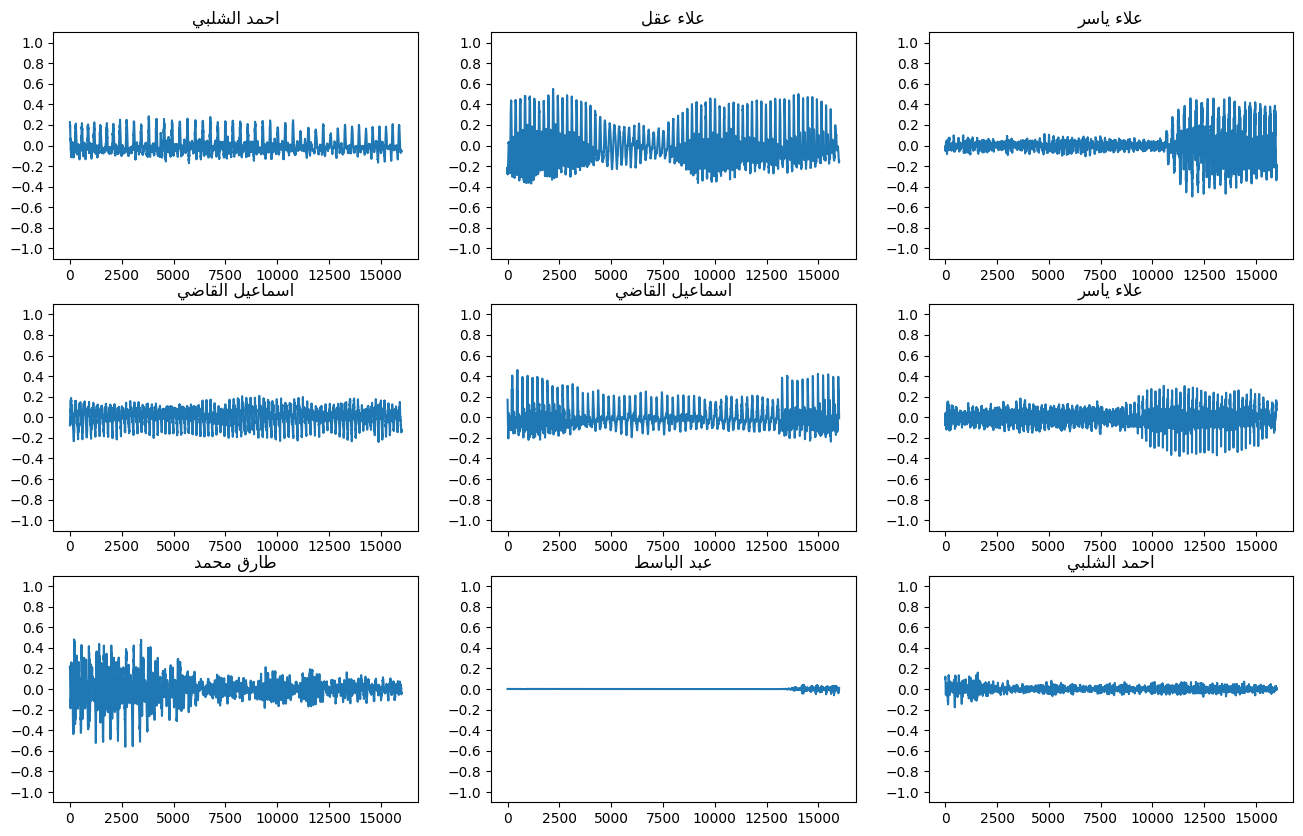

In [8]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(get_display(arabic_reshaper.reshape(label_names[example_labels[i]])))
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [9]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [10]:
for i in range(5):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: احمد الشلبي
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: علاء عقل
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: علاء ياسر
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: اسماعيل القاضي
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: اسماعيل القاضي
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [11]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

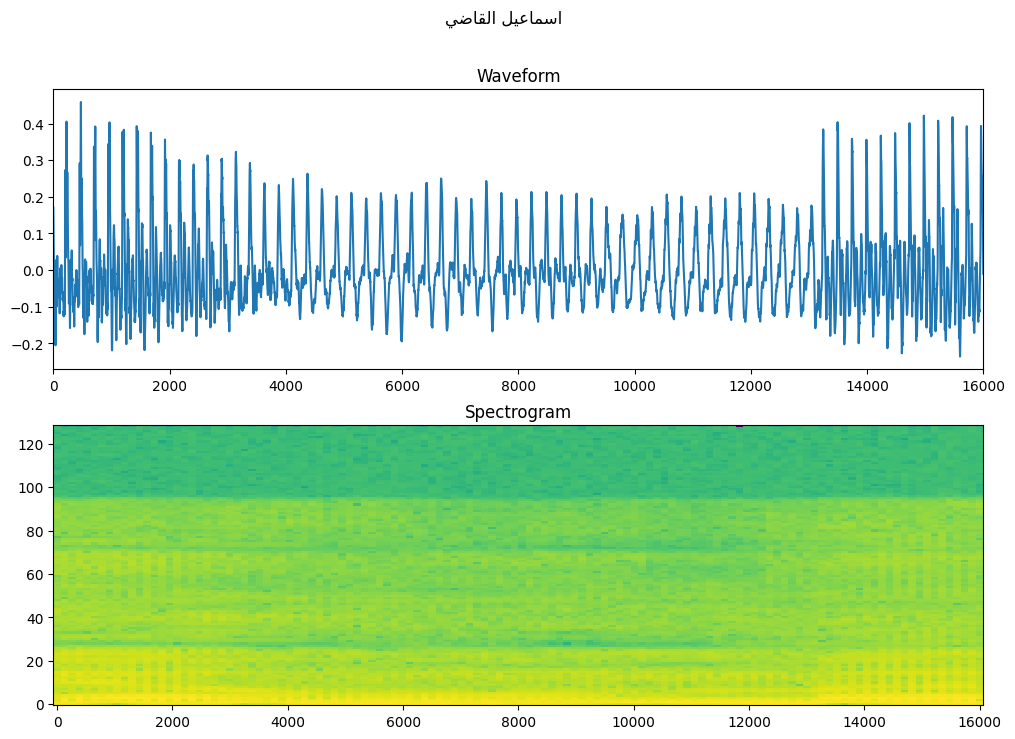

In [12]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(get_display(arabic_reshaper.reshape(label.title())))
plt.show()


Now, create spectrogram datasets from the audio datasets:

In [13]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [15]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

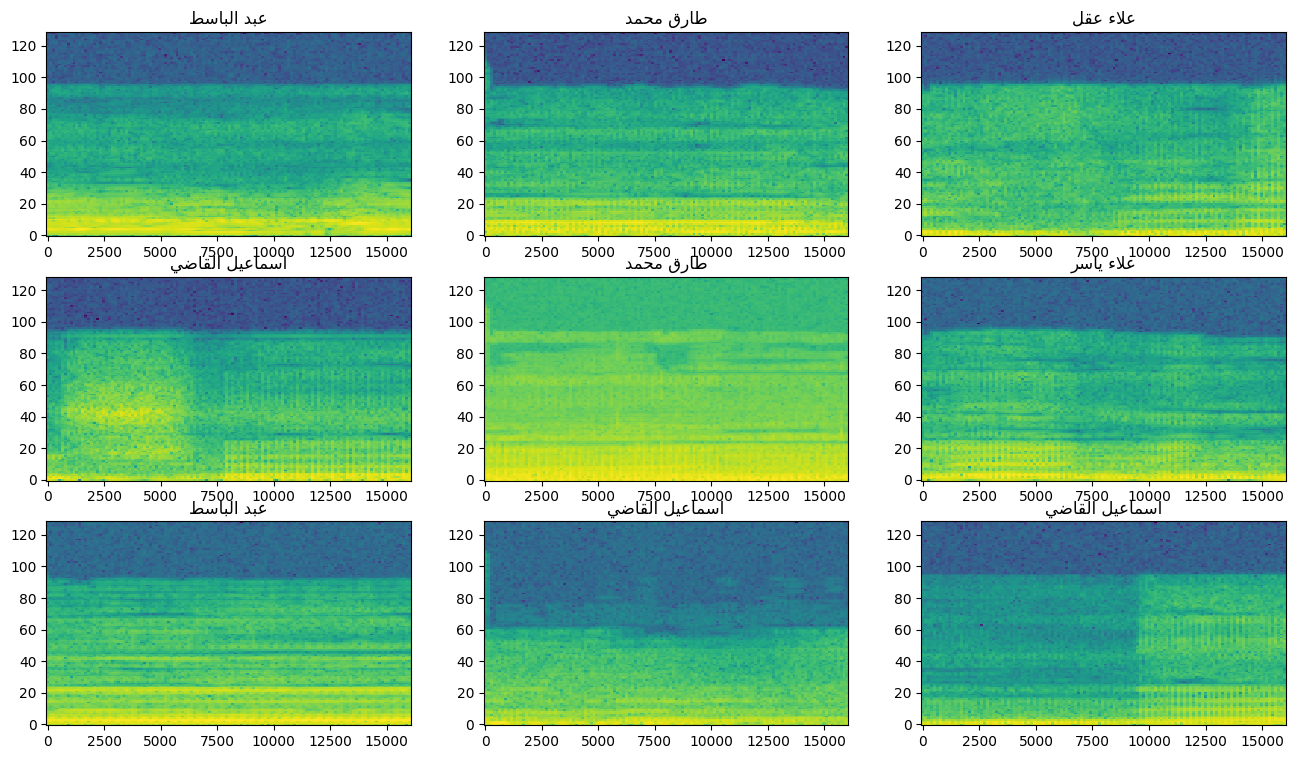

In [16]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(get_display(arabic_reshaper.reshape(label_names[example_spect_labels[i].numpy()])))

plt.show()

## Build and train the model

In [17]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [18]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)


norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2024-02-17 14:31:10.688514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 41 of 10000
2024-02-17 14:31:20.788198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 73 of 10000
2024-02-17 14:31:40.654312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 167 of 10000
2024-02-17 14:32:00.887168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 261 of 10000
2024-02-17 14:32:20.776306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 343 of 10000
2024-02-17 14:32:27.576471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [20]:
EPOCHS = 90
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/90


2024-02-17 14:32:37.312125: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-17 14:32:37.805942: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-17 14:32:42.510574: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efacc4b9350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-17 14:32:42.510627: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-17 14:32:42.573512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708173162.768207 3807009 device_compiler.h:186] Compiled clust

376/380 [============================>.] - ETA: 0s - loss: 0.8489 - accuracy: 0.6974

2024-02-17 14:32:50.641611: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 8190464 bytes after encountering the first element of size 8190464 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


380/380 [==============================] - 35s 72ms/step - loss: 0.8458 - accuracy: 0.6985 - val_loss: 0.4943 - val_accuracy: 0.8256
Epoch 2/90
380/380 [==============================] - 5s 13ms/step - loss: 0.5163 - accuracy: 0.8194 - val_loss: 0.3868 - val_accuracy: 0.8654
Epoch 3/90
380/380 [==============================] - 5s 12ms/step - loss: 0.4307 - accuracy: 0.8490 - val_loss: 0.3311 - val_accuracy: 0.8825
Epoch 4/90
380/380 [==============================] - 5s 12ms/step - loss: 0.3895 - accuracy: 0.8637 - val_loss: 0.2981 - val_accuracy: 0.8964
Epoch 5/90
380/380 [==============================] - 5s 13ms/step - loss: 0.3607 - accuracy: 0.8757 - val_loss: 0.2740 - val_accuracy: 0.9041
Epoch 6/90
380/380 [==============================] - 5s 13ms/step - loss: 0.3282 - accuracy: 0.8841 - val_loss: 0.2644 - val_accuracy: 0.9054
Epoch 7/90
380/380 [==============================] - 5s 13ms/step - loss: 0.3132 - accuracy: 0.8901 - val_loss: 0.2558 - val_accuracy: 0.9104
Epoch 8/9

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

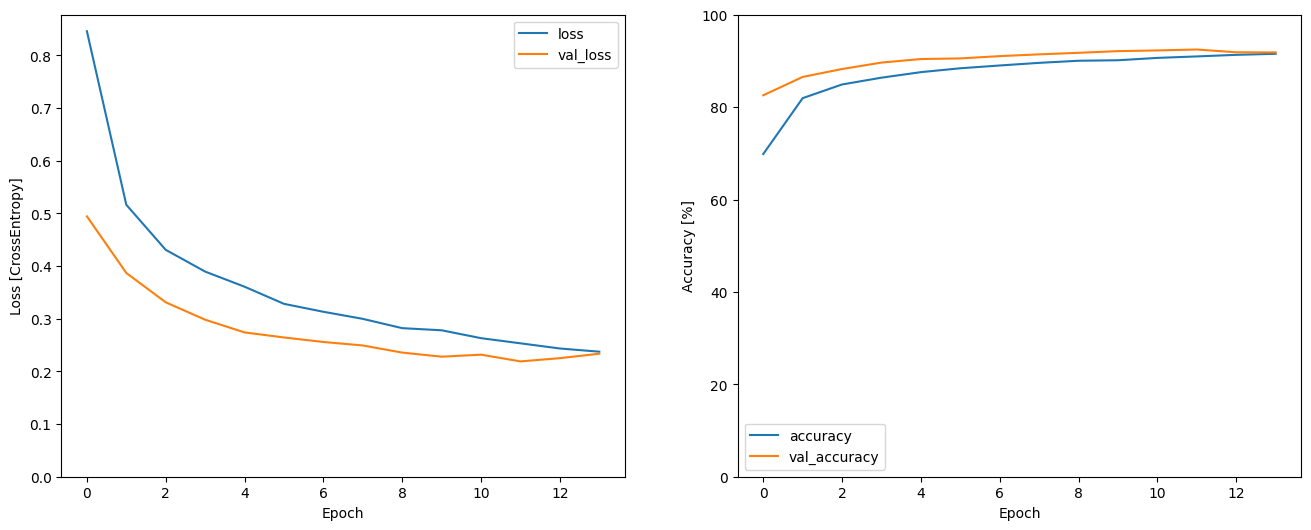

In [21]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [22]:
model.evaluate(test_spectrogram_ds, return_dict=True)

48/48 [==============================] - 21s 431ms/step - loss: 0.2242 - accuracy: 0.9185


{'loss': 0.22424335777759552, 'accuracy': 0.9185305833816528}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [23]:
y_pred = model.predict(test_spectrogram_ds)

48/48 [==============================] - 0s 5ms/step


In [24]:
y_pred = tf.argmax(y_pred, axis=1)

In [25]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

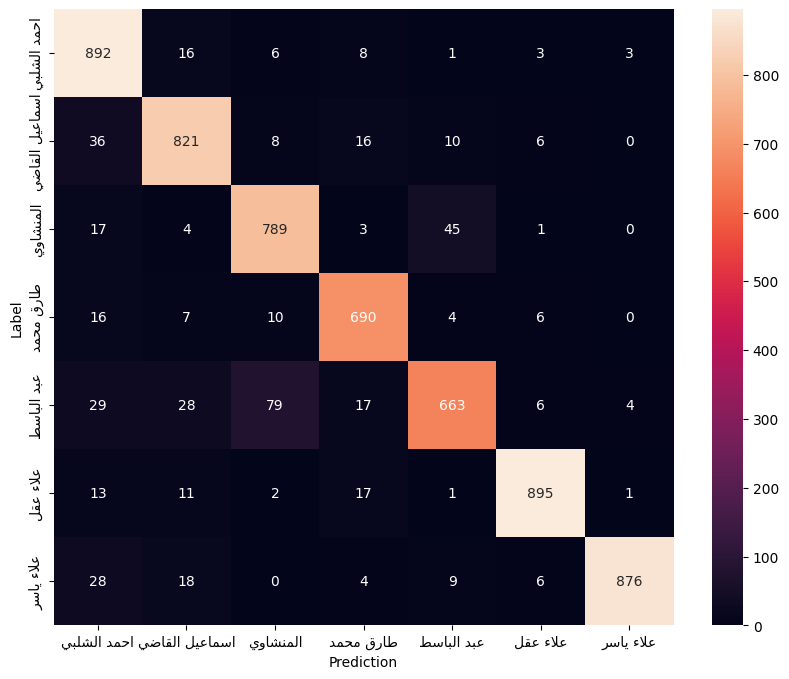

In [26]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# Convert label names to strings with reshaping
reshaped_label_names = [get_display(arabic_reshaper.reshape(label)) for label in label_names]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=reshaped_label_names, yticklabels=reshaped_label_names, annot=True, fmt='g')

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

In [27]:
x = "test_examples/hegazy.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
print(x.shape)
x = tf.squeeze(x, axis=-1)
# waveform = get_random_segment(x)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = sorted(os.listdir("quran"))
label = tf.argmax(tf.nn.softmax(prediction[0]))
print(x_labels[label])

display.display(display.Audio(waveform, rate=16000))

(16000, 1)
المنشاوي


/home/mahran/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
/home/mahran/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


In [28]:
tf.argmax(tf.nn.softmax(prediction[0]))

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [29]:
x = "test_examples/AHMAD.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)

x = tf.squeeze(x, axis=-1)
waveform=x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

# x_resized = tf.image.resize(x, (343, 129))
# x_resized = x_resized[..., tf.newaxis]
prediction = model(x)
label_names
x_labels = sorted(os.listdir("quran"))
label = tf.argmax(tf.nn.softmax(prediction[0]))
print(label_names[label])

display.display(display.Audio(waveform, rate=16000))

احمد الشلبي


In [63]:
print(label_names)

['احمد الشلبي' 'اسماعيل القاضي' 'المنشاوي' 'طارق محمد' 'عبد الباسط'
 'علاء عقل' 'علاء ياسر']


## Export the model with preprocessing

In [31]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [32]:
export = ExportModel(model)
export(tf.constant(str("output_folder/one_second_audio.mp3.wav")))

{'predictions': <tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[-12.918542, -12.469369,  14.212523,  -4.071853,   6.869604,
         -16.868729, -16.992504]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=
 array([b'\xd8\xa7\xd9\x84\xd9\x85\xd9\x86\xd8\xb4\xd8\xa7\xd9\x88\xd9\x8a'],
       dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [33]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
pred = imported("output_folder/one_second_audio.mp3.wav")
class_names=pred['class_names']
class_id=np.argmax(pred['class_ids'],-1)
final_pred=class_names[class_id]

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


In [34]:
final_pred.numpy().decode('utf-8')

'المنشاوي'

In [43]:
pred['class_ids']

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([4])>